# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [19]:
import xarray as xr
import matplotlib
import xesmf as xe
import numpy as np
import pandas as pd
import polars as pl
import os, sys

In [20]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"

## Natural Land Sink

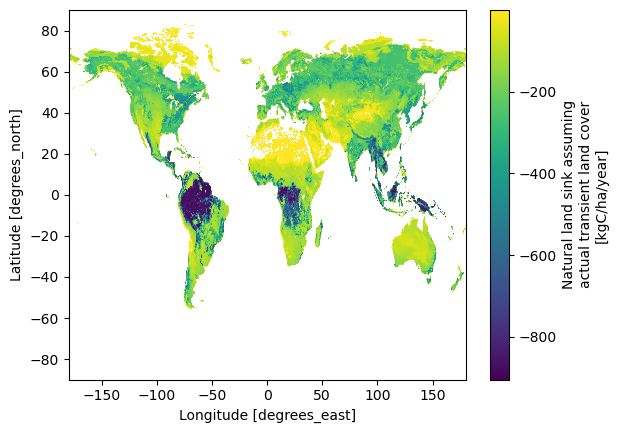

In [21]:
# Natural Land Sink (0.5 arcdegrees)
LandSink = xr.open_dataset(rawDir + "landSinkDorgeist.nc")
LandSink.SLAND_trans.plot()

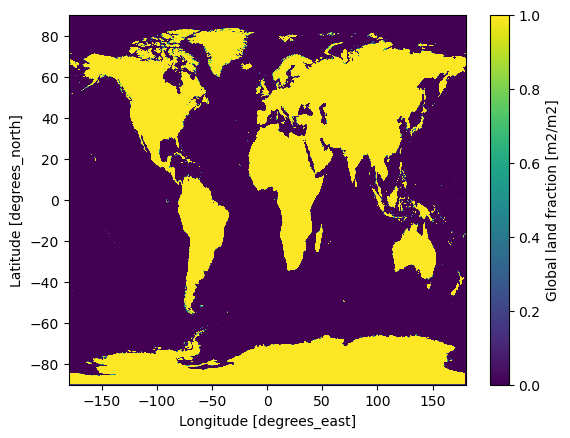

In [22]:
# Country mask (0.1 arcdegrees)
countryMask = xr.open_dataset(
    rawDir + "Country-mask_UNFCCC_layers-all-countries_grid-3600x1800.nc"
)

countryMask.land_fraction_global.plot()

In [23]:
print(LandSink)

<xarray.Dataset> Size: 12MB
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon          (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    SLAND_trans  (lat, lon) float32 4MB ...
    SLAND_pi     (lat, lon) float32 4MB ...
    RSS          (lat, lon) float32 4MB ...
Attributes:
    title:    Environmental contribution to ELUC in 2021-2021
    history:  Created with xarray in python


In [24]:
print(countryMask)

<xarray.Dataset> Size: 10GB
Dimensions:               (lon: 3600, lat: 1800, ISOcode: 199)
Coordinates:
  * lon                   (lon) float64 29kB -179.9 -179.8 ... 179.9 180.0
  * lat                   (lat) float64 14kB -89.95 -89.85 ... 89.85 89.95
  * ISOcode               (ISOcode) float64 2kB 4.0 24.0 ... 9.999e+03 5.555e+03
Data variables:
    land_fraction         (ISOcode, lat, lon) float64 10GB ...
    land_fraction_global  (lat, lon) float64 52MB ...
Attributes:
    CDI:                   Climate Data Interface version 2.0.3 (https://mpim...
    Conventions:           CF-1.6
    CDO:                   Climate Data Operators version 2.0.3 (https://mpim...
    ISO_code_explanation:  4: AFG, 24: AGO, 8: ALB, 20: AND, 784: ARE, 32: AR...


### Regrid countryMask to Match natLandSink Resolution

In [25]:
# Inspect the coordinates
print(LandSink.coords)
print(countryMask.coords)

Coordinates:
  * lat      (lat) float32 3kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Coordinates:
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * ISOcode  (ISOcode) float64 2kB 4.0 24.0 8.0 ... 716.0 9.999e+03 5.555e+03


In [14]:
# Regrid `countryMask` to match `natLandSink` coordinates
regridder = xe.Regridder(countryMask, LandSink, method="conservative")
countryMask_regridded_dor = regridder(countryMask)

In [15]:
countryMask_regridded_dor.to_netcdf(interimDir + "countryMask_regridded_dor.nc")

In [16]:
# Inspect the coordinates
print(countryMask_regridded_dor.coords)

Coordinates:
  * ISOcode  (ISOcode) float64 2kB 4.0 24.0 8.0 ... 716.0 9.999e+03 5.555e+03
  * lat      (lat) float32 3kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9


In [26]:
# Load datasets
countryMask_regridded_dor = xr.open_dataset(interimDir + "countryMask_regridded_dor.nc")
country_codes = pd.read_excel(rawDir + "Country-codes_UNFCCC_199countries.xlsx")
country_codes["Numeric"] = country_codes["Numeric"].astype(int)

# Get list of country codes
ctrs_UNFCCC = country_codes["Alpha-3"]

In [27]:
# Get lat and lon names
if "latitude" in LandSink.dims:
    lat_name, lon_name = "latitude", "longitude"
else:
    lat_name, lon_name = "lat", "lon"

# Check that model grid and country grid agree
check_lat1 = np.max(
    np.abs(LandSink[lat_name].values - countryMask_regridded_dor[lat_name].values)
)
check_lon1 = np.max(
    np.abs(LandSink[lon_name].values - countryMask_regridded_dor[lon_name].values)
)
if check_lat1 > 0.001 or check_lon1 > 0.001:
    sys.exit("Coordinates do not agree")

# Re-index if there are small deviations in lat and lon
if (check_lat1 != 0) or (check_lon1 != 0):
    countryMask_regridded_dor = countryMask_regridded_dor.reindex(
        {lat_name: LandSink[lat_name], lon_name: LandSink[lon_name]},
        method="nearest",
    )

In [19]:
help(xe.util.cell_area)

Help on function cell_area in module xesmf.util:

cell_area(ds, earth_radius=None)
    Get cell area of a grid, assuming a sphere.

    Parameters
    ----------
    ds : xarray Dataset
        Input grid, longitude and latitude required.
        Curvilinear coordinate system also require cell bounds to be present.
    earth_radius : float, optional
        Earth radius, assuming a sphere, in km.

    Returns
    -------
    area : xarray DataArray
        Cell area. If the earth radius is given, units are km^2, otherwise they are steradian (sr).



In [28]:
# Compute grid areas (in km^2) for natLandSink
grid_areas_km2 = xe.util.cell_area(LandSink, earth_radius=6371.0)  # Earth radius in km

# Convert kgC/ha/year to GtC/year (global scale)
# Scale factor calculation
LandSink = LandSink.SLAND_trans * 100 * 1e-12 * grid_areas_km2
LandSink = LandSink.fillna(0)

In [34]:
print(LandSink)

<xarray.DataArray (lat: 720, lon: 1440)> Size: 8MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float32 3kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9


In [29]:
# Dictionary for storing country data
data_ctrs_dor = dict()

# Loop over all country codes
for i, iso_alpha3 in enumerate(ctrs_UNFCCC):

    if np.mod(i, 20) == 0:
        print(f"  - processing country {i + 1} of {len(ctrs_UNFCCC)}")

    # Get numeric ISO code for the country
    iso_numeric = country_codes["Numeric"][
        country_codes["Alpha-3"] == iso_alpha3
    ].values[0]

    # Extract country mask for the current country
    mask = countryMask_regridded_dor.sel(ISOcode=iso_numeric)

    # Weight by fraction of country-specific land area
    weights = mask.land_fraction / mask.land_fraction_global

    # Sum up the natural land sink for the selected country
    data_sel = (LandSink * weights).sum((lat_name, lon_name))

    # Store results in dictionary
    data_ctrs_dor[iso_alpha3] = data_sel.values

  - processing country 1 of 199
  - processing country 21 of 199
  - processing country 41 of 199
  - processing country 61 of 199
  - processing country 81 of 199
  - processing country 101 of 199
  - processing country 121 of 199
  - processing country 141 of 199
  - processing country 161 of 199
  - processing country 181 of 199


In [30]:
##### Add fluxes in ocean grid cells to closest county ####

# Select only ocean grid cells that have non-zero land sink values
data_ocean = LandSink.where(countryMask_regridded_dor.land_fraction_global == 0)
data_ocean = data_ocean.where(data_ocean != 0)

# Get 2D arrays with latitudes and longitudes and keep only country areas
LON, LAT = np.meshgrid(countryMask_regridded_dor.lon, countryMask_regridded_dor.lat)

# Apply the mask to latitude and longitude arrays
LAT[countryMask_regridded_dor.land_fraction_global == 0] = np.nan
LON[countryMask_regridded_dor.land_fraction_global == 0] = np.nan


# Convert latitudes and longitudes to radians for distance calculation
LAT_rad = LAT * np.pi / 180
LON_rad = LON * np.pi / 180

In [ ]:
# Loop over all grid cells to assign ocean grid values to closest country cells
for i_lat in range(0, len(data_ocean.lat)):
    for i_lon in range(0, len(data_ocean.lon)):

        # Read land sink data for the specific grid cell
        data_sel = data_ocean.isel(lat=i_lat, lon=i_lon)

        # Only process ocean grid cells with non-zero land sink values
        if not np.isnan(data_sel):

            # Get latitude and longitude of the ocean grid cell and convert to radians
            lat_ocean = data_sel.lat.item() * np.pi / 180
            lon_ocean = data_sel.lon.item() * np.pi / 180

            # Calculate the argument for arccos
            argument = np.sin(lat_ocean) * np.sin(LAT_rad) + np.cos(lat_ocean) * np.cos(
                LAT_rad
            ) * np.cos(lon_ocean - LON_rad)
            argument = np.clip(argument, -1, 1)  # Clip to avoid invalid values

            # Calculate distances
            distance = np.arccos(argument)

            # Find the closest land grid cell(s)
            index_closest = np.argwhere(distance == np.nanmin(distance))

            # Loop over closest grid cells and add values to the corresponding country
            for ind in index_closest:

                # Get latitude and longitude of the closest grid cell
                lat_sel = LAT[ind[0], ind[1]]
                lon_sel = LON[ind[0], ind[1]]

                # Select the land_fraction at the specified lat, lon
                land_fraction_at_point = countryMask_regridded_dor.sel(
                    lat=lat_sel, lon=lon_sel
                ).land_fraction

                # Find the index where land_fraction is non-zero
                non_zero_index = np.where(land_fraction_at_point.values != 0)[0]

                # There should only be one non-zero value, retrieve the corresponding ISOcode
                if len(non_zero_index) == 1:
                    iso_code = countryMask_regridded_dor.ISOcode[
                        non_zero_index[0]
                    ].values
                    print(f"ISO Code for the given lat, lon: {iso_code}")
                else:
                    print("No or multiple countries found for this lat, lon")

                # Retrieve country name for the ISO code
                ctr_name = country_codes["Alpha-3"][
                    country_codes["Numeric"] == iso_code
                ].values[0]

                # Add the ocean grid cell's natural land sink value to the closest country's data
                data_ctrs_dor[ctr_name] += data_sel.values / len(index_closest)

ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0
ISO Code for the given lat, lon: 795.0


In [32]:
# Convert data_ctrs to a DataFrame with country names as the index
data_ctrs_dor_df = pd.DataFrame(
    list(data_ctrs_dor.items()), columns=["iso", "Land_Sink"]
)

# Sort the DataFrame by 'Country' column if needed
data_ctrs_dor_df = data_ctrs_dor_df.sort_values(
    "Land_Sink", ascending=False
).reset_index(drop=True)

# Add units to the DataFrame and save to Excel
data_ctrs_dor_df.to_excel(processedDir + "land_sink_by_country_dor.xlsx", index=False)

data_ctrs_dor_df.to_csv(processedDir + "land_sink_by_country_dor.csv")

In [18]:
total_land_sink_Gt_per_yr = data_ctrs_dor_df["Land_Sink"].sum()
Sland_sum = (LandSink).sum(dim=["lat", "lon"]).item()
print(
    "Country Sum Land Sink (Gt per yr) conservative method:", total_land_sink_Gt_per_yr
)

print("Total Grid Cell Sum Land Sink (Gt per yr) :", Sland_sum)

Country Sum Land Sink (Gt per yr) conservative method: -2.993104980287183
Total Grid Cell Sum Land Sink (Gt per yr) : -2.9931169301458533


check if the sum of the land fraction over all countries equals the total land fraction in the remapped country mask

## Fossil and Industry CO2 emissions

## Inclusive Wealth Calculations

### Country Social Cost of Carbon

In [33]:
# Read the CSV using pandas
cscc = pd.read_csv(
    rawDir + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs_lineartrend.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

# Show the first few rows to check
print(cscc.head())

       mean       10%       25%       50%       75%       90%            ID  \
0  0.005771  0.002139  0.003110  0.004218  0.007508  0.012430  2_1p5_NA_AFG   
1  0.193915  0.146453  0.161908  0.185704  0.224977  0.246136  2_1p5_NA_AGO   
2  0.003214  0.001607  0.002301  0.002832  0.004133  0.005066  2_1p5_NA_ALB   
3  0.899642  0.671506  0.718220  0.820168  1.066469  1.239778  2_1p5_NA_ARE   
4  0.207296  0.101300  0.159885  0.200887  0.264989  0.304651  2_1p5_NA_ARG   

   iso   dr elasmu  prtp  
0  AFG  NaN    1p5   2.0  
1  AGO  NaN    1p5   2.0  
2  ALB  NaN    1p5   2.0  
3  ARE  NaN    1p5   2.0  
4  ARG  NaN    1p5   2.0  
